In [1]:
import numpy as np
from load_data.get_satellites import satellite, get_satellites
from load_data.get_ground_stations import ground_station, get_ground_station
from load_data.load_tle import parse_tle
from skyfield.api import load
from model.distribution_efficiency_sat2sat import communication_loss_sat2sat
from model.distribution_efficiency_stat2sat import communication_loss_stat2sat

tle_path = './dataset/satellite_tle.txt'
satellite_tle_data = parse_tle(tle_path)

In [2]:
# 提取有效时间窗口
def extract_valid_windows(data, threshold=0):
    # 找到大于阈值的索引
    indices = np.where(data > threshold)[0]
    # 通过对连续索引分组提取时间窗口
    windows = np.split(indices, np.where(np.diff(indices) != 1)[0] + 1)
    # 只返回长度大于0的窗口
    valid_windows = [window for window in windows if len(window) > 0]
    return valid_windows

In [3]:
def calculate_key_generation_rate(eta, R_source, QBER, QBER_threshold=0.11):
    """
    Calculate the key generation rate for quantum communication using E91 protocol,
    considering a QBER threshold.

    Parameters:
    eta (float): Transmission efficiency (0 <= eta <= 1)
    R_source (float): Photon pair emission rate per second from the quantum source
    QBER (float): Quantum Bit Error Rate (0 <= QBER <= 1)
    QBER_threshold (float): The maximum acceptable QBER for key generation (default is 0.11)

    Returns:
    float: Key generation rate in bits per second. Returns 0 if QBER is above the threshold.
    """
    # Check if QBER is within the acceptable range
    if QBER > QBER_threshold:
        return 0  # No key is generated if the QBER is too high

    # Calculate the raw key rate considering the transmission efficiency and the emission rate
    S_raw = 0.5 * eta * R_source  # 50% probability of choosing each basis
    
    # Calculate the final key rate considering the QBER
    key_generation_rate = S_raw * (1 - 2 * QBER)
    
    return key_generation_rate


In [4]:
# 定义卫星列表
satellites = ['STARLINK-1094', 'STARLINK-1102', 'STARLINK-1144', 'STARLINK-1156']

# 创建一个字典来存储每颗卫星的效率历史数据
satellite_data = {}
valid_windows_dict = {}  # 创建一个字典来存储每颗卫星的有效时间窗口


In [5]:
# 循环每个卫星，读取存储的效率历史数据
for sat in satellites:
    file_path = f'E:\starlink_quantum\dataset/efficiency_history_{sat}.json.npy'  # 使用.npy文件格式
    efficiency_history = np.load(file_path)  # 使用numpy.load读取数据
    satellite_data[sat] = efficiency_history  # 存储到字典中
    valid_windows_dict[sat] = extract_valid_windows(satellite_data[sat])

In [6]:
import numpy as np
import random

def simulate_key_rates_with_adjusted_windows(valid_windows_dict, satellite_data, qber_no_eve, qber_with_eve, R_source, satellite_tle_data, primary_satellite='STARLINK-1094', total_attackers=1500):
    total_satellites = len(satellite_data)
    all_key_rates = np.zeros(len(satellite_data[primary_satellite]))
    switch_success_count = 0
    switch_failure_count = 0

    def attempt_reshedule(current_satellite, already_searched, start_window_id, previous_start_time, switch_success_count,  switch_failure_count):
        
        current_windows = valid_windows_dict[current_satellite]
        next_window_used = False
        for idx in range(start_window_id, len(current_windows)):
            if idx != start_window_id:
                already_searched = set()
                
            # Check if we're on the next window after a successful switch
            if idx == start_window_id + 1 and (current_satellite != primary_satellite or start_window_id !=0):
                switch_success_count += 1
            
            targeted_satellites = random.sample(list(satellite_tle_data), total_attackers) #random attack
            
            window = current_windows[idx]
            window_start = window[0]

            if current_satellite in targeted_satellites:
                can_switch, new_satellite, new_window_id = can_switch_to_another_satellite(window_start , valid_windows_dict, current_satellite, already_searched)
                if can_switch:
                    print(f"Switching from {current_satellite} to {new_satellite} at second {max(valid_windows_dict[new_satellite][new_window_id][0], previous_start_time+15, window_start+15)}")
                    already_searched.add(new_satellite) 
                    #valid_windows_dict[new_satellite][0]
                    return attempt_reshedule(new_satellite, already_searched, new_window_id, max(valid_windows_dict[new_satellite][new_window_id][0], previous_start_time+15, window_start+15), switch_success_count,  switch_failure_count)
                else:
                    qber = qber_with_eve  # No available satellite to switch or all are monitored
                    switch_failure_count +=1
            else:
                qber = qber_no_eve  # Current satellite not targeted

             # Update key rates for the current window
            for second in range(max(window_start, previous_start_time), window[-1] + 1):
                eta = satellite_data[current_satellite][second]
                key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
                all_key_rates[second] = key_rate

        return all_key_rates, switch_success_count,  switch_failure_count  # Return all_key_rates

    # Start the simulation with the initial satellite and an empty set for already searched satellites
    return attempt_reshedule(primary_satellite, set(), 0, 0, switch_success_count,  switch_failure_count)

def can_switch_to_another_satellite(start_second, valid_windows_dict, current_satellite, already_searched):
    switch_time_start = start_second + 10
    switch_time_end = start_second + 60
    for sat, windows in valid_windows_dict.items():
        if sat == current_satellite or sat in already_searched:
            continue
        for idx, window in enumerate(windows):
            window_start = window[0]
            window_end = window[-1]
            if window_start <= switch_time_end and window_end >= switch_time_start:
                return True, sat, idx  # 返回卫星名、索引
    return False, None, None  # 如果找不到合适的卫星，返回False和None

In [7]:
qber_no_eve = 0.045
qber_with_eve = 0.25
R_source = 10000000000
QBER_threshold = 0.11
# Assuming the other necessary functions and variables are defined as needed.
all_key_rates, switch_success_count,  switch_failure_count = simulate_key_rates_with_adjusted_windows(valid_windows_dict, satellite_data, qber_no_eve, qber_with_eve, R_source, satellite_tle_data, primary_satellite='STARLINK-1094', total_attackers=1500)


Switching from STARLINK-1094 to STARLINK-1102 at second 15
Switching from STARLINK-1102 to STARLINK-1094 at second 412061
Switching from STARLINK-1094 to STARLINK-1144 at second 417771
Switching from STARLINK-1144 to STARLINK-1094 at second 699912
Switching from STARLINK-1094 to STARLINK-1144 at second 761889
Switching from STARLINK-1144 to STARLINK-1094 at second 927959
Switching from STARLINK-1094 to STARLINK-1144 at second 927974
Switching from STARLINK-1144 to STARLINK-1094 at second 1013960
Switching from STARLINK-1094 to STARLINK-1144 at second 1112095
Switching from STARLINK-1144 to STARLINK-1094 at second 1180204
Switching from STARLINK-1094 to STARLINK-1144 at second 1186014
Switching from STARLINK-1144 to STARLINK-1094 at second 1186029
Switching from STARLINK-1094 to STARLINK-1144 at second 1272046
Switching from STARLINK-1144 to STARLINK-1094 at second 1272061
Switching from STARLINK-1094 to STARLINK-1102 at second 1296142
Switching from STARLINK-1102 to STARLINK-1094 at se

In [8]:
cumulative_keys_dict_with_reschedule = np.cumsum(all_key_rates)

In [9]:
cumulative_keys_dict_with_reschedule[-1]

2838812028.4803166

In [10]:
def simulate_key_rates(listening_frequency, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source):
    all_key_rates = np.zeros(len(efficiency_history))
    for window in valid_windows:
        if random.random() < listening_frequency:
            qber = qber_with_eve
        else:
            qber = qber_no_eve
        for second in window:
            eta = efficiency_history[second]
            key_rate = calculate_key_generation_rate(eta, R_source, qber, QBER_threshold)
            all_key_rates[second] = key_rate
    return np.cumsum(all_key_rates)

In [11]:
# 使用提取函数
valid_windows = valid_windows_dict['STARLINK-1094']

# 输出结果查看
for i, window in enumerate(valid_windows[:10]):  # 只打印前5个窗口以示例
    print(f"Window {i+1}: Start {window[0]}, End {window[-1]}, Length {len(window)}")

Window 1: Start 0, End 294, Length 295
Window 2: Start 5730, End 6334, Length 605
Window 3: Start 11720, End 12426, Length 707
Window 4: Start 17694, End 18431, Length 738
Window 5: Start 23791, End 24160, Length 370
Window 6: Start 68058, End 68142, Length 85
Window 7: Start 73692, End 74367, Length 676
Window 8: Start 79649, End 80344, Length 696
Window 9: Start 85712, End 86321, Length 610
Window 10: Start 91760, End 92375, Length 616


In [12]:
# 配置参数
total_satellites = len( satellite_tle_data)
attackers_counts = [0,250, 500, 1000, 1500]  # 包含0攻击者的情况用作基线
listening_frequencies = [attackers / total_satellites for attackers in attackers_counts]

# 模拟每种监听频率下的密钥生成
cumulative_keys_dict_no_reschedule = {}
for freq, attackers in zip(listening_frequencies, attackers_counts):
    cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    cumulative_keys_dict_no_reschedule[attackers] = cumulative_keys  # 存储每种情况的最终累积密钥数量

In [13]:
baseline_keys = cumulative_keys_dict_no_reschedule[0]  # 0攻击者的情况

losses = {}
for attackers in attackers_counts[0:]:  
    lost_keys = baseline_keys - cumulative_keys_dict_no_reschedule[attackers]
    loss_percentage = (lost_keys / baseline_keys[-1]) * 100
    losses[attackers] = (lost_keys, loss_percentage)

loss_with_reschedule = (baseline_keys - cumulative_keys_dict_with_reschedule) / baseline_keys[-1] * 100

In [14]:
cumulative_keys_dict_with_reschedule

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.83881203e+09, 2.83881203e+09, 2.83881203e+09])

In [15]:
import matplotlib.pyplot as plt

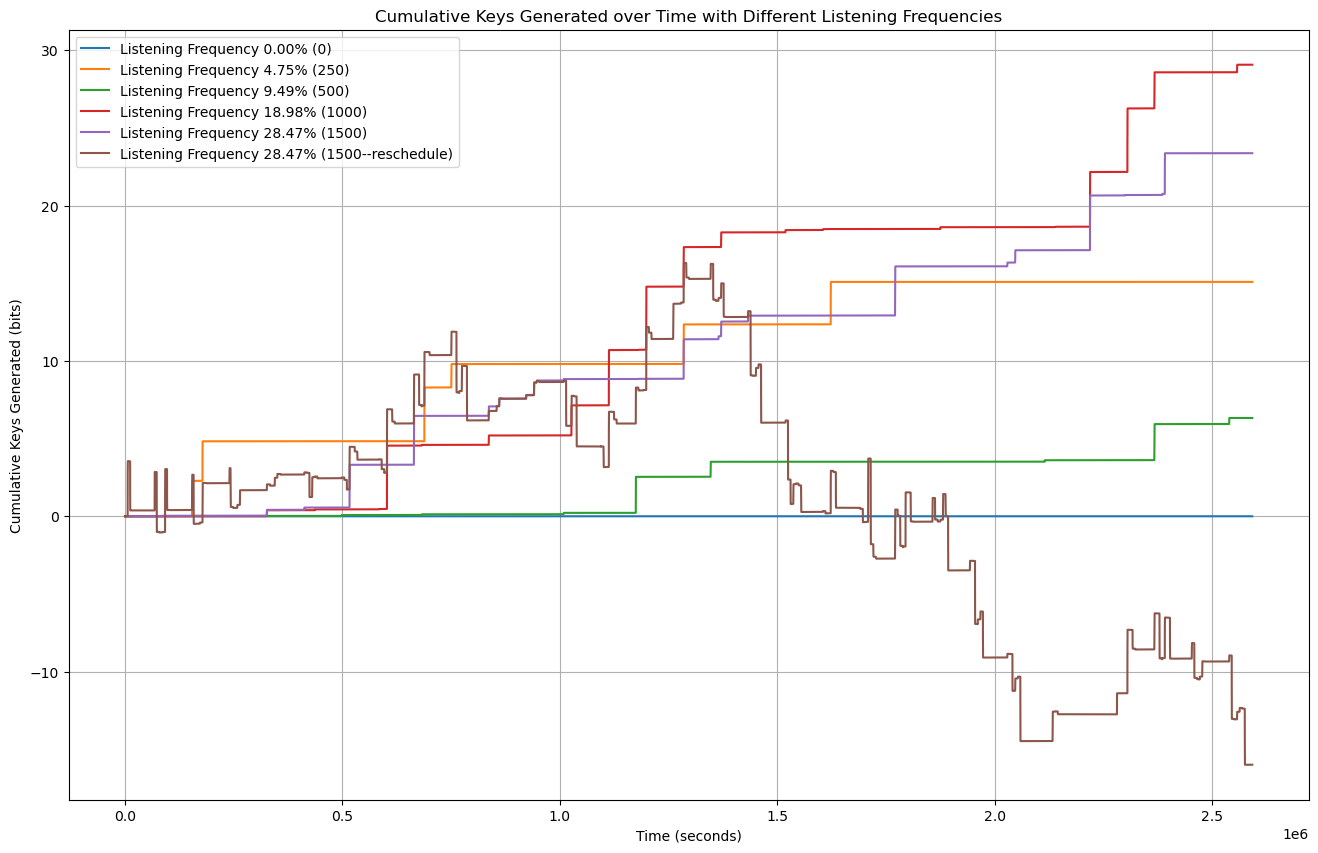

In [16]:
# 准备绘图
plt.figure(figsize=(16, 10))
labels = [f'{count} attackers' for count in attackers_counts]
for freq, label in zip(listening_frequencies, attackers_counts):
    #print(freq)
    plt.plot(losses[label][1], label=f'Listening Frequency {freq*100:.2f}% ({label})')


plt.plot(loss_with_reschedule, label=f'Listening Frequency {freq*100:.2f}% ({label}--reschedule)')

plt.xlabel('Time (seconds)')
plt.ylabel('Cumulative Keys Generated (bits)')
plt.title('Cumulative Keys Generated over Time with Different Listening Frequencies')
plt.legend()
plt.grid(True)
plt.show()

# Experiment 3

In [17]:
# 使用提取函数
valid_windows = valid_windows_dict['STARLINK-1094']

# 输出结果查看
for i, window in enumerate(valid_windows[:10]):  # 只打印前5个窗口以示例
    print(f"Window {i+1}: Start {window[0]}, End {window[-1]}, Length {len(window)}")

Window 1: Start 0, End 294, Length 295
Window 2: Start 5730, End 6334, Length 605
Window 3: Start 11720, End 12426, Length 707
Window 4: Start 17694, End 18431, Length 738
Window 5: Start 23791, End 24160, Length 370
Window 6: Start 68058, End 68142, Length 85
Window 7: Start 73692, End 74367, Length 676
Window 8: Start 79649, End 80344, Length 696
Window 9: Start 85712, End 86321, Length 610
Window 10: Start 91760, End 92375, Length 616


In [18]:
# 配置参数
total_satellites = len( satellite_tle_data)
attackers_counts = [250, 500, 1000, 1500]  # 包含0攻击者的情况用作基线
listening_frequencies = [attackers / total_satellites for attackers in attackers_counts]

# 模拟每种监听频率下的密钥生成
cumulative_keys_dict_no_reschedule = {}
for freq, attackers in zip(listening_frequencies, attackers_counts):
    cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    cumulative_keys_dict_no_reschedule[attackers] = cumulative_keys  # 存储每种情况的最终累积密钥数量

In [19]:
# 模拟每种监听频率下的密钥生成
cumulative_keys_dict_with_reschedule = {}

for freq, attackers in zip(listening_frequencies, attackers_counts):
    all_key_rates, switch_success_count,  switch_failure_count = simulate_key_rates_with_adjusted_windows(valid_windows_dict, satellite_data, qber_no_eve, qber_with_eve, R_source, satellite_tle_data, primary_satellite='STARLINK-1094', total_attackers=attackers)
    cumulative_keys_with_reschedule = np.cumsum(all_key_rates)
    #cumulative_keys = simulate_key_rates(freq, valid_windows, efficiency_history, qber_no_eve, qber_with_eve, R_source)
    cumulative_keys_dict_with_reschedule[attackers] = cumulative_keys_with_reschedule  # 存储每种情况的最终累积密钥数量

Switching from STARLINK-1094 to STARLINK-1144 at second 245766
Switching from STARLINK-1144 to STARLINK-1094 at second 1972318
Switching from STARLINK-1094 to STARLINK-1156 at second 68073
Switching from STARLINK-1156 to STARLINK-1094 at second 263873
Switching from STARLINK-1094 to STARLINK-1156 at second 497891
Switching from STARLINK-1156 to STARLINK-1094 at second 694071
Switching from STARLINK-1094 to STARLINK-1144 at second 853996
Switching from STARLINK-1144 to STARLINK-1094 at second 1118071
Switching from STARLINK-1094 to STARLINK-1144 at second 1210086
Switching from STARLINK-1144 to STARLINK-1094 at second 1800275
Switching from STARLINK-1094 to STARLINK-1144 at second 1978339
Switching from STARLINK-1144 to STARLINK-1094 at second 2120308
Switching from STARLINK-1094 to STARLINK-1144 at second 2206327
Switching from STARLINK-1144 to STARLINK-1094 at second 2206342
Switching from STARLINK-1094 to STARLINK-1144 at second 2218438
Switching from STARLINK-1144 to STARLINK-1094 a

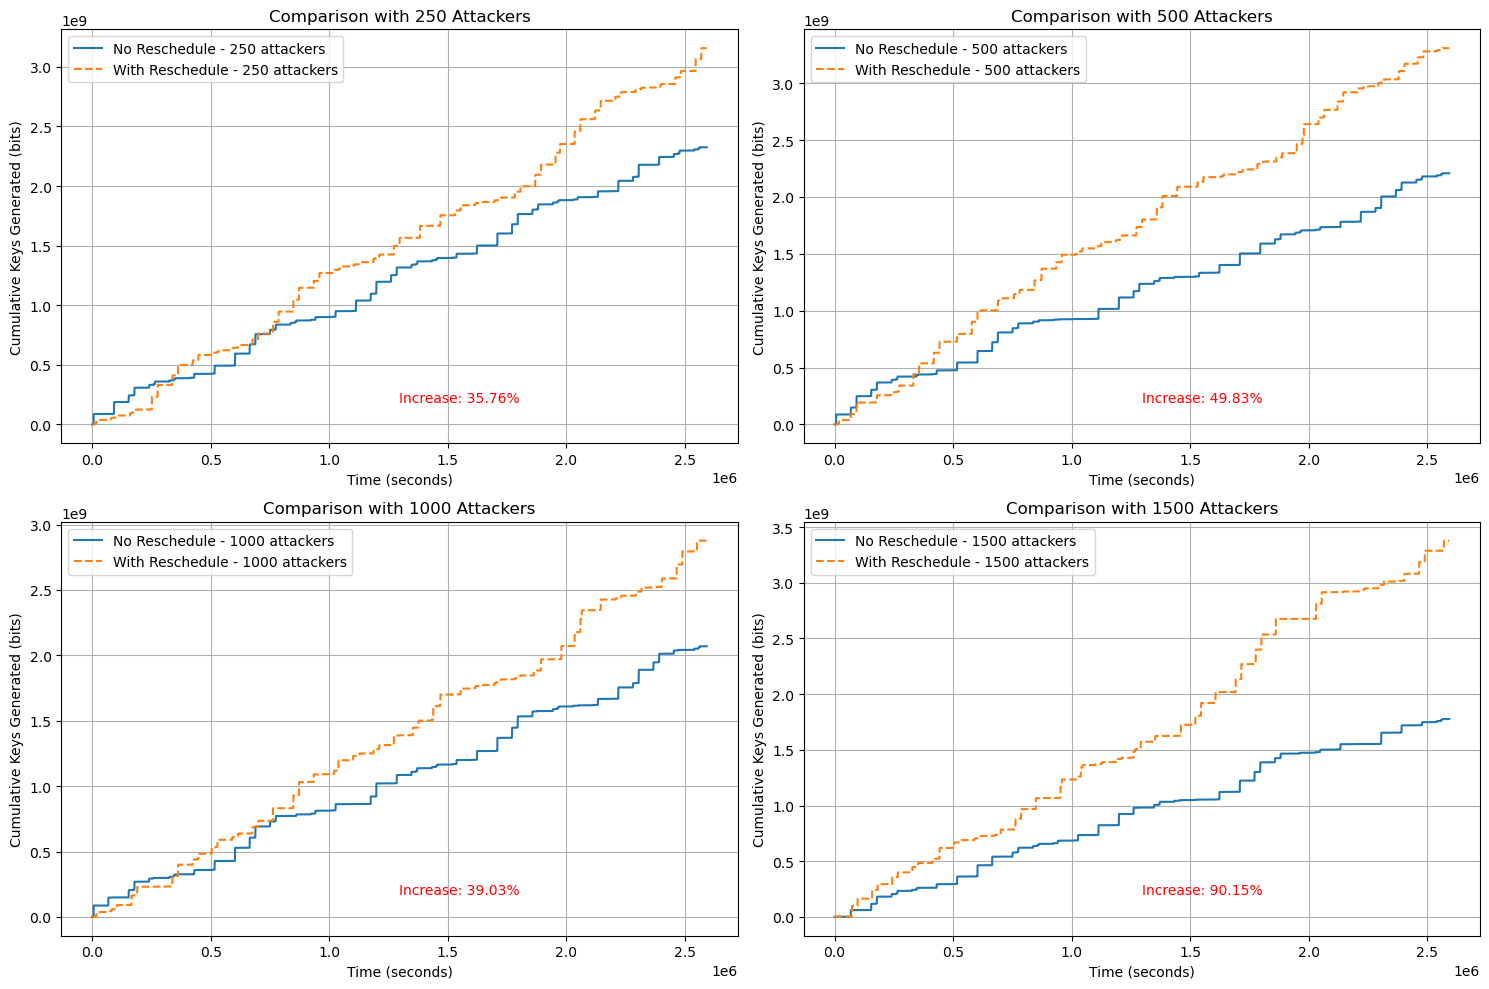

In [20]:
import matplotlib.pyplot as plt

# 假设 attackers_counts = [0, 250, 500, 1000, 1500] 已包含0攻击者基线情况
attackers_counts = [0, 250, 500, 1000, 1500]

# 绘图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()  # 展平轴数组以便使用单循环

for idx, attackers in enumerate(attackers_counts[1:]):  # 跳过0攻击者的基线情况
    ax = axes[idx]
    # 无重调度情况
    ax.plot(cumulative_keys_dict_no_reschedule[attackers], label=f'No Reschedule - {attackers} attackers')
    # 有重调度情况
    ax.plot(cumulative_keys_dict_with_reschedule[attackers], label=f'With Reschedule - {attackers} attackers', linestyle='--')

    ax.set_title(f'Comparison with {attackers} Attackers')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Cumulative Keys Generated (bits)')
    ax.legend()
    ax.grid(True)

    # 计算损失百分比
    keys_no_reschedule = cumulative_keys_dict_no_reschedule[attackers][-1]
    keys_with_reschedule = cumulative_keys_dict_with_reschedule[attackers][-1]
    loss_percentage = 100 * (keys_with_reschedule-keys_no_reschedule) / keys_no_reschedule if keys_no_reschedule else 0
    ax.text(0.5, 0.1, f'Increase: {loss_percentage:.2f}%', transform=ax.transAxes, color='red')

plt.tight_layout()
plt.show()


In [22]:
import json
from matplotlib.ticker import ScalarFormatter
from datetime import datetime, timedelta, timezone

specific_time = datetime(2024, 1, 1, 0, 0, 0, tzinfo=timezone.utc)
start_time = specific_time
end_time = specific_time+timedelta(days = 30)

time_step = timedelta(seconds = 1)

time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step )]

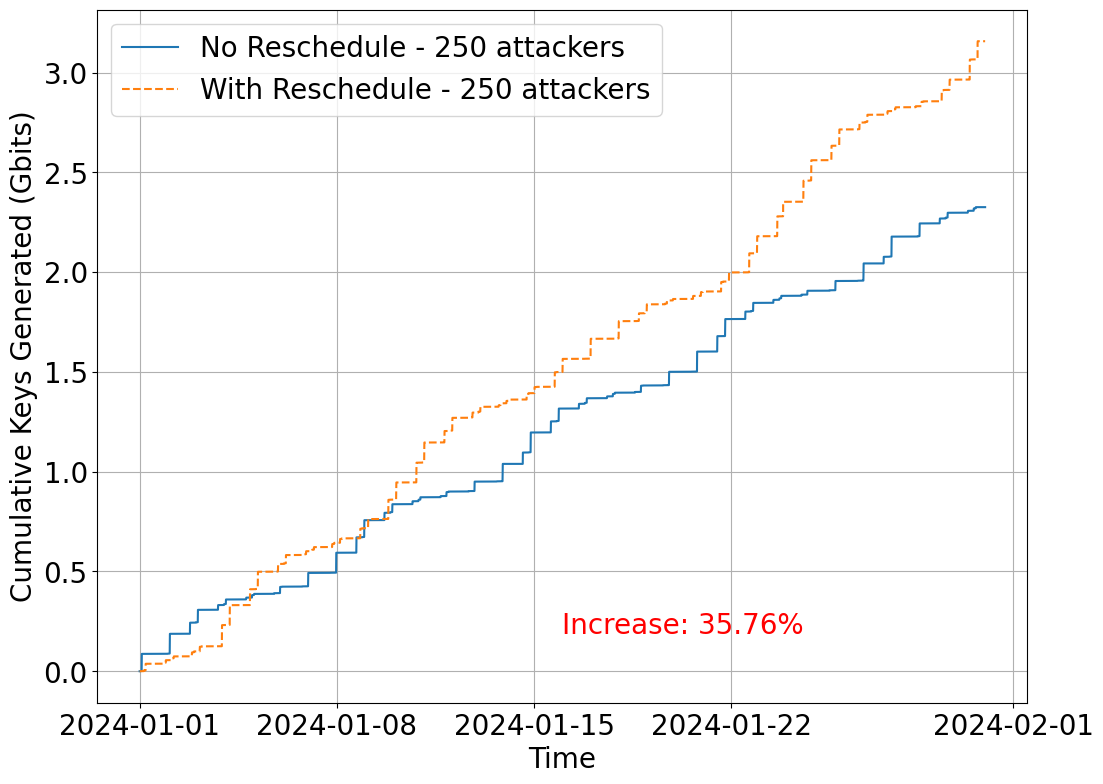

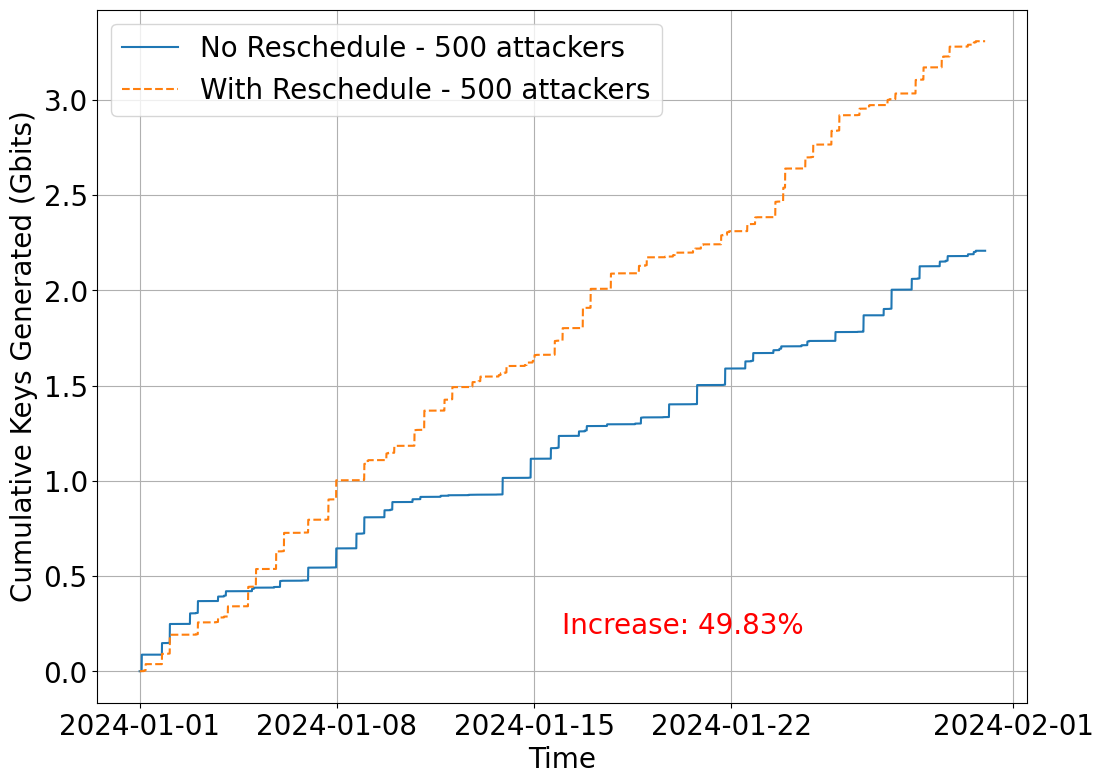

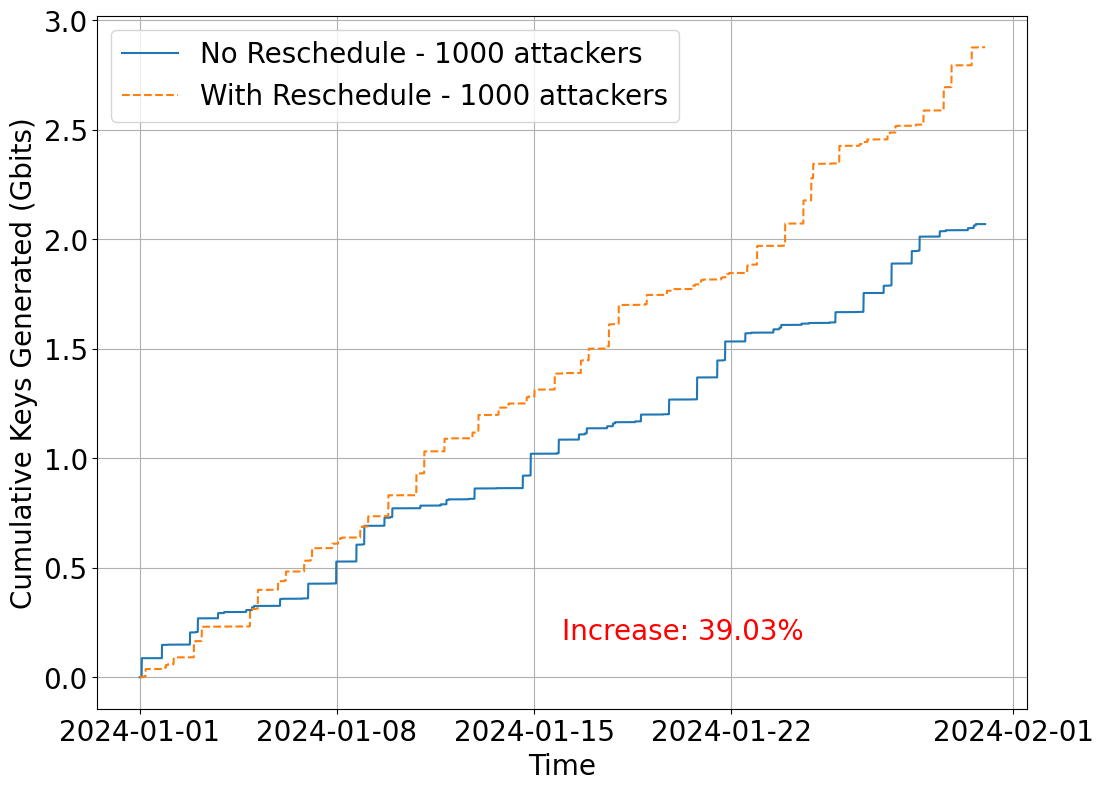

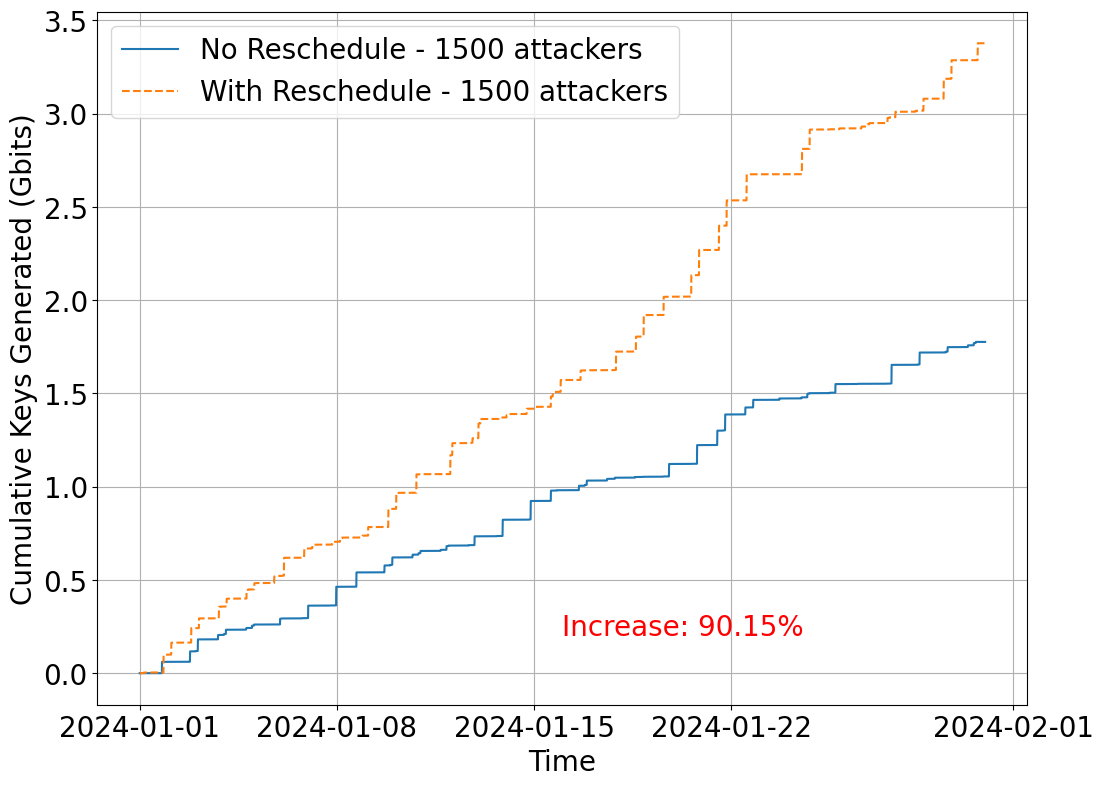

In [31]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# List of attacker counts
attackers_counts = [0, 250, 500, 1000, 1500]

# Plotting each graph separately
for attackers in attackers_counts[1:]:  # Skip baseline case with 0 attackers
    plt.figure(figsize=(12, 9))
    
    # Plot without rescheduling
    plt.plot(time_series, cumulative_keys_dict_no_reschedule[attackers]/1e9, label=f'No Reschedule - {attackers} attackers')
    
    # Plot with rescheduling
    plt.plot(time_series, cumulative_keys_dict_with_reschedule[attackers]/1e9, label=f'With Reschedule - {attackers} attackers', linestyle='--')
    
    #plt.title(f'Comparison with {attackers} Attackers')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Keys Generated (Gbits)')
    plt.legend()
    plt.grid(True)

    locator = mdates.AutoDateLocator(minticks=6, maxticks=6)
    formatter = mdates.AutoDateFormatter(locator)
    
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    # Calculate loss percentage
    keys_no_reschedule = cumulative_keys_dict_no_reschedule[attackers][-1]
    keys_with_reschedule = cumulative_keys_dict_with_reschedule[attackers][-1]
    loss_percentage = 100 * (keys_with_reschedule - keys_no_reschedule) / keys_no_reschedule if keys_no_reschedule else 0
    plt.text(0.5, 0.1, f'Increase: {loss_percentage:.2f}%', transform=plt.gca().transAxes, color='red', fontsize=20)
    plt.rcParams.update({'font.size': 20})

    plt.show()
